In [1]:
import requests
import pandas as pd

LOAD FPL API

In [2]:
url = "https://fantasy.premierleague.com/api/bootstrap-static/"
response = requests.get(url)
data = response.json()

players = data['elements']  # List of player data
teams = data['teams']       # List of team data

In [3]:
# Create DataFrames
players = pd.DataFrame(data['elements'])  # Player data
teams = pd.DataFrame(data['teams'])      # Team data

CLEAN DATAFRAMES

In [4]:
# Drop unnecessary columns
players = players[['web_name', 'team', 'element_type', 'form', 'minutes', 'total_points', 'now_cost', 'transfers_in']]

# Fill missing values (e.g., form might have NaNs)
players['form'] = pd.to_numeric(players['form'], errors='coerce').fillna(0)

# Create additional features
players['value'] = players['now_cost'] / 10  # Convert cost to decimal format
players['points_per_minute'] = players['total_points'] / players['minutes'].replace(0, 1)

# Merge team names
team_mapping = dict(zip(teams['id'], teams['name']))
players['team_name'] = players['team'].map(team_mapping)


VISUALIZE DATA

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

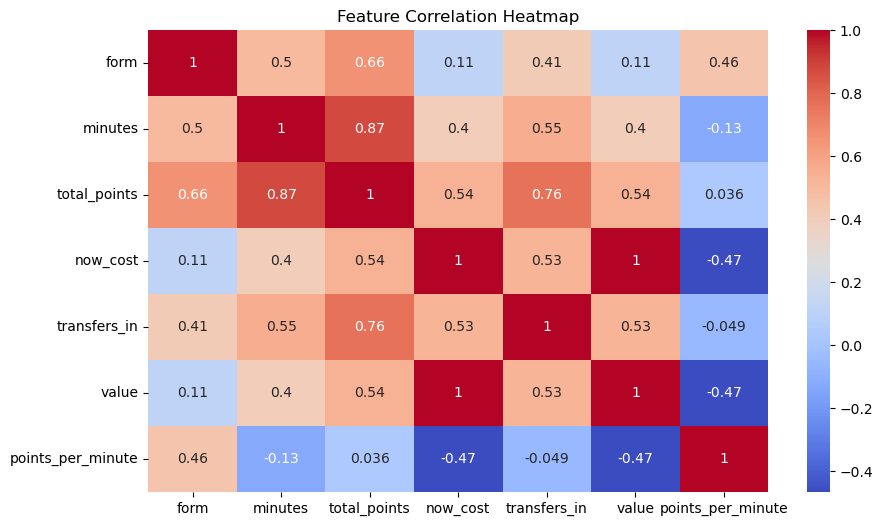

In [6]:
# Select numeric columns
numeric_features = ['form', 'minutes', 'total_points', 'now_cost', 'transfers_in', 'value', 'points_per_minute']

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(players[numeric_features].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


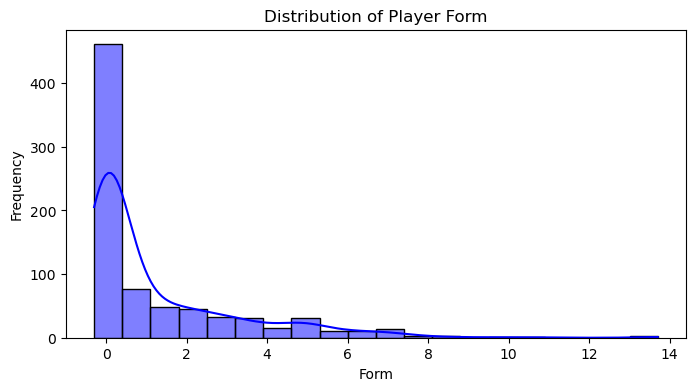

In [7]:
# Distribution of form
plt.figure(figsize=(8, 4))
sns.histplot(players['form'], bins=20, kde=True, color='blue')
plt.title("Distribution of Player Form")
plt.xlabel("Form")
plt.ylabel("Frequency")
plt.show()

Upper Outlier Players:
Kluivert (Midfielder)
Mbeumo (Midfielder)
Palmer (Midfielder)
M.Salah (Midfielder)
Haaland (Forward)
Isak (Forward)
Wood (Forward)
Gabriel (Defender)
Saliba (Defender)
Muñoz (Defender)
Alexander-Arnold (Defender)
Virgil (Defender)
Gvardiol (Defender)
Hall (Defender)
Aina (Defender)
Milenković (Defender)
Raya (Goalkeeper)
Pickford (Goalkeeper)
Sels (Goalkeeper)


/var/folders/1x/d63v0p1x0t7cpz8_8l_1n7rm0000gn/T/ipykernel_88153/482374948.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='position', y='total_points', data=players, palette='Set3')


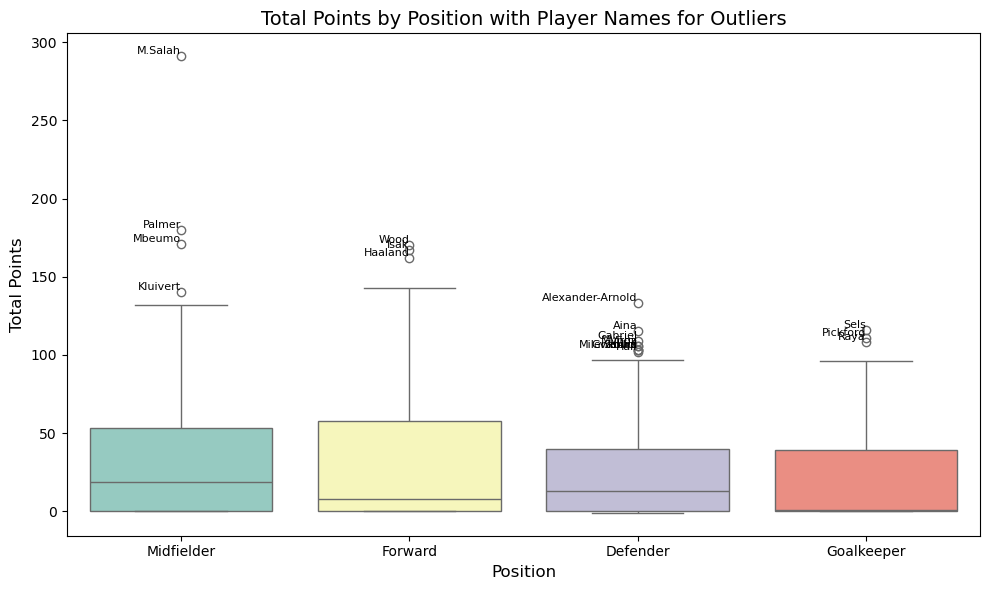

In [8]:
# Map element_type to position names
position_mapping = {1: 'Goalkeeper', 2: 'Defender', 3: 'Midfielder', 4: 'Forward'}
players['position'] = players['element_type'].map(position_mapping)

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='position', y='total_points', data=players, palette='Set3')

# Prepare to collect outlier information
outlier_data = []

# Add player names to the outlier dots
for position in players['position'].unique():
    pos_data = players[players['position'] == position]
    Q1 = pos_data['total_points'].quantile(0.25)
    Q3 = pos_data['total_points'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = pos_data[pos_data['total_points'] > upper_bound]
    
    # Collect outlier data
    outlier_data.extend(outliers[['web_name', 'position']].values.tolist())
    
    # Annotate player names on the plot
    for _, row in outliers.iterrows():
        plt.text(
            x=position, 
            y=row['total_points'], 
            s=row['web_name'], 
            ha='right', 
            va='bottom', 
            fontsize=8, 
            color='black'
        )

# Print outlier names with positions
print("Upper Outlier Players:")
for name, position in outlier_data:
    print(f"{name} ({position})")

# Add titles and labels
plt.title("Total Points by Position with Player Names for Outliers", fontsize=14)
plt.xlabel("Position", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


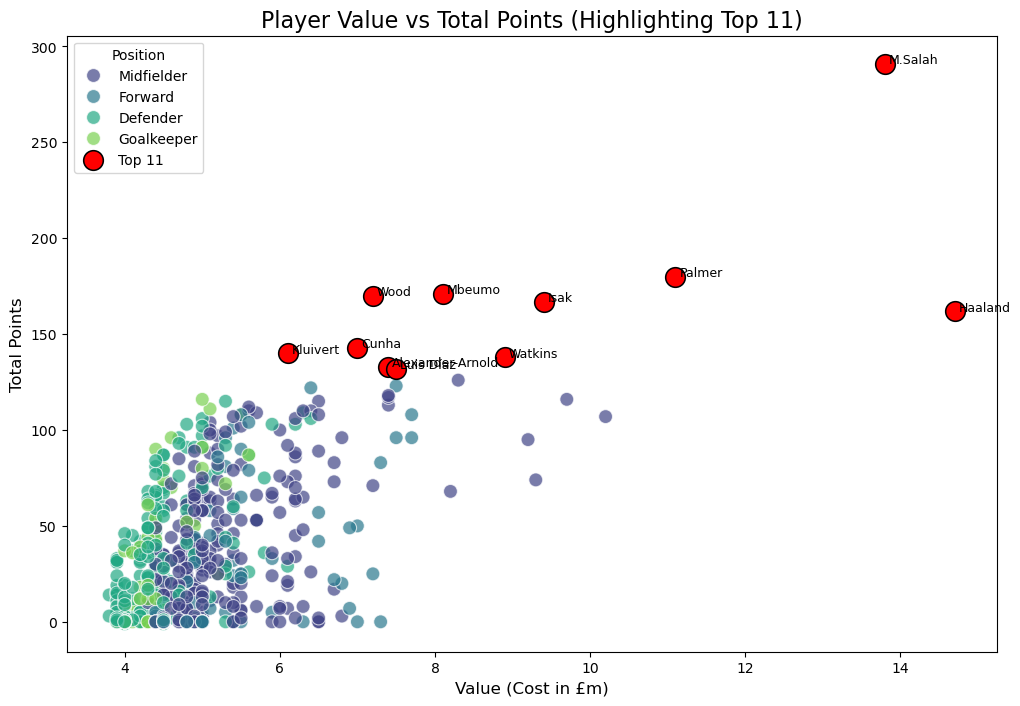

In [9]:
# Sort players by total points and select the top 11
top_11 = players.nlargest(11, 'total_points')

# Create scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='value', y='total_points', data=players, hue='position', palette='viridis', alpha=0.7, s=100)

# Highlight top 11 players with a different marker and color
sns.scatterplot(x='value', y='total_points', data=top_11, color='red', edgecolor='black', s=200, label='Top 11')

# Annotate top 11 players
for i, row in top_11.iterrows():
    plt.text(row['value'] + 0.05, row['total_points'], row['web_name'], fontsize=9, color='black')

# Add titles and labels
plt.title("Player Value vs Total Points (Highlighting Top 11)", fontsize=16)
plt.xlabel("Value (Cost in £m)", fontsize=12)
plt.ylabel("Total Points", fontsize=12)
plt.legend(title="Position")
plt.show()

/var/folders/1x/d63v0p1x0t7cpz8_8l_1n7rm0000gn/T/ipykernel_88153/673953476.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_points', y='team_name', data=team_points.sort_values('total_points', ascending=False), palette='coolwarm')


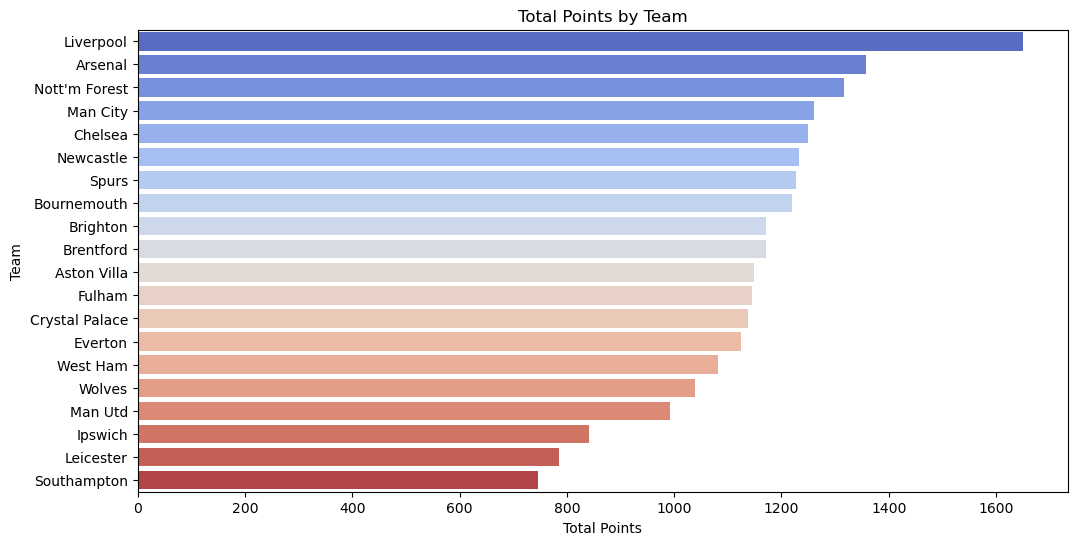

In [10]:
# Aggregate total points by team
team_points = players.groupby('team_name')['total_points'].sum().reset_index()

# Bar plot of team performance
plt.figure(figsize=(12, 6))
sns.barplot(x='total_points', y='team_name', data=team_points.sort_values('total_points', ascending=False), palette='coolwarm')
plt.title("Total Points by Team")
plt.xlabel("Total Points")
plt.ylabel("Team")
plt.show()


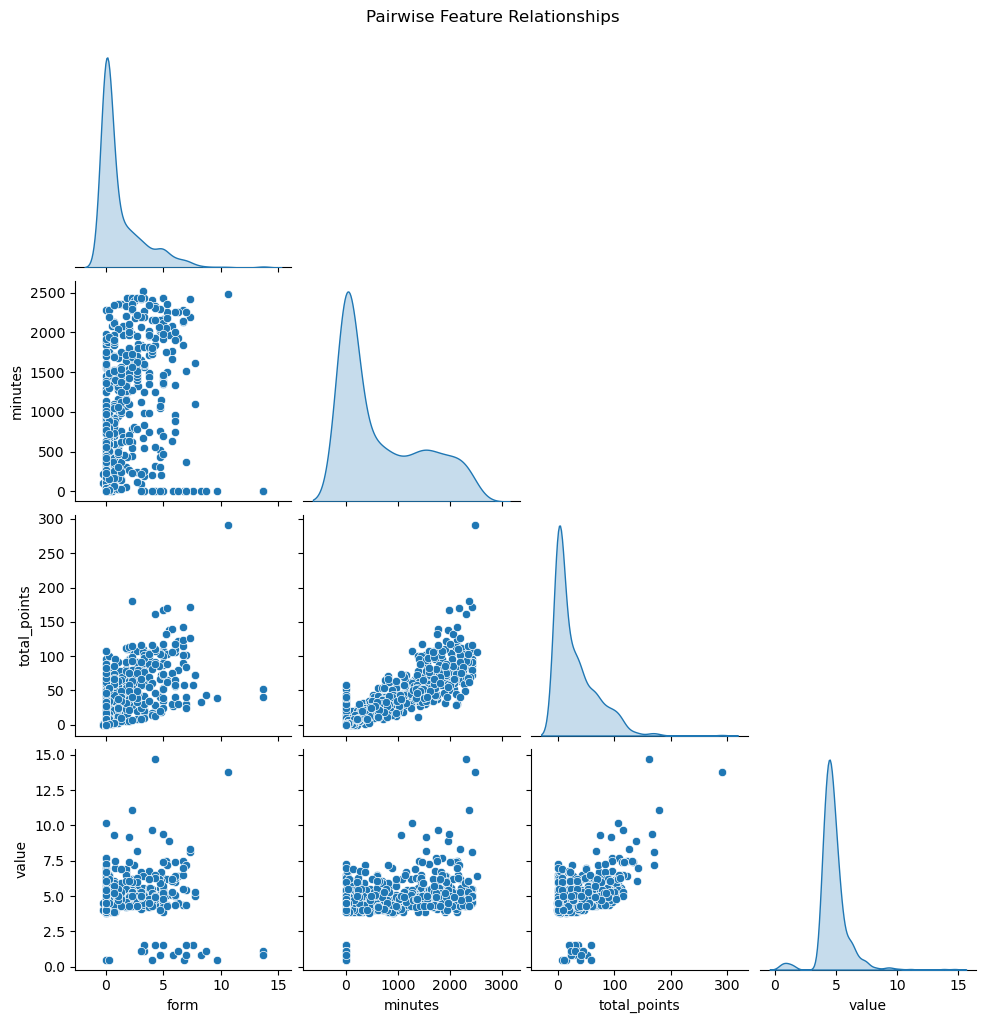

In [11]:
sns.pairplot(players[['form', 'minutes', 'total_points', 'value']], diag_kind='kde', corner=True)
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()